# (FI) Applying Accumulated Local Effects on Fixed Intervals

In [1]:
import alibi
from alibi.explainers import ALE, plot_ale
import warnings
warnings.filterwarnings("ignore")
from alibi.explainers import PartialDependence
from sklearn.inspection import PartialDependenceDisplay
from alibi.explainers import plot_pd
from alibi.explainers import TreePartialDependence

In [2]:
alibi.explainers.__all__

['ALE',
 'AnchorTabular',
 'DistributedAnchorTabular',
 'AnchorText',
 'AnchorImage',
 'CEM',
 'Counterfactual',
 'CounterfactualProto',
 'CounterfactualRL',
 'CounterfactualRLTabular',
 'plot_ale',
 'PartialDependence',
 'TreePartialDependence',
 'PartialDependenceVariance',
 'PermutationImportance',
 'plot_pd',
 'plot_pd_variance',
 'plot_permutation_importance',
 'IntegratedGradients',
 'KernelShap',
 'TreeShap',
 'GradientSimilarity']

# Tree Sites

In [3]:
# -*- coding: utf-8 -*-
"""
Created on Thu Apr  4 17:58:38 2024

@author: krish
"""

import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_validate
import graphviz 

import sys
sys.path.append('/Users/krish/Desktop/DYNAMIC MODEL VEGETATION PROJECT/au_dyanamic_vegetation_project/STEP9_DATA_MODELLING_AND_EXPLORATION')

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from PreprocessData import * # import from custom transformers
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import permutation_importance
from skopt import BayesSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import GroupKFold

#%% Functions 

def plotPredictions(actual, prediction, TARGET, msg = '', split = ''):
    fig, ax = plt.subplots(nrows = 3, figsize = (15,10))
    fig.suptitle(msg, fontsize=30)
    for i,v in enumerate(TARGET):
        actual[v].plot(ax=ax[i], color = 'blue', alpha = 0.4, linestyle='dashed' )
        prediction[f'prediction_{v}'].plot(ax=ax[i], color = 'orange', ylim = (0,100))
        ax[i].legend()
        if split:
            ax[i].axvline(time_split, color='black', ls='--')
            
def antiOverFitterScorer(y_train_pred, y_train_act, y_val_pred, y_val_act):
    train_score = -mean_squared_error(y_train_pred, y_train_act)
    val_score = -mean_squared_error(y_val_pred, y_val_act)
    score = ((train_score + val_score)/2) * val_score/train_score
    return score

tree_sites = ['NSABBS0001', 'NSACOP0001', 'NSAMDD0011', 'NSAMDD0020',
       'NSAMUL0003', 'NSANAN0001', 'NSANAN0002', 'NSANSS0001',
       'NSANSS0002', 'NSTSYB0003', 'NSTSYB0006', 'NTAFIN0003',
       'NTAFIN0015', 'NTAGFU0030', 'NTAGFU0034', 'QDABBN0002',
       'QDACHC0003', 'QDACYP0020', 'QDAGUP0006', 'QDAMGD0025',
       'QDAMUL0002', 'QDAMUL0003', 'QDASEQ0004', 'SAAFLB0008',
       'SATFLB0003', 'SATFLB0020', 'SATFLB0022', 'TCATCH0004',
       'WAACAR0002', 'WAAGAS0001', 'WAAPIL0023']

shrub_sites = ['NSABHC0011', 'NSAMDD0028', 'NSTSYB0005', 'NTAFIN0018',
       'QDABBS0010', 'QDACYP0018', 'QDAGUP0021', 'SAAEYB0021',
       'SAAEYB0028', 'SAAFLB0005', 'SAAGAW0008', 'SAAKAN0009',
       'SAASTP0023', 'SAASTP0033', 'SAASTP0034', 'SASMDD0009',
       'SASMDD0014', 'SATFLB0023', 'WAACAR0004', 'WAACOO0007',
       'WAACOO0016', 'WAACOO0024', 'WAACOO0026', 'WAACOO0027',
       'WAACOO0029', 'WAAGES0001', 'WAALSD0002', 'WAANUL0003',
       'WAAPIL0010']

grass_sites = ['NSABHC0023', 'NSAMDD0001', 'NSAMDD0014', 'NTADAC0001',
       'NTADMR0001', 'NTAFIN0002', 'NTAFIN0006', 'NTAGFU0014',
       'NTAGFU0020', 'NTAGFU0021', 'NTASTU0004', 'NTTDMR0003',
       'QDABBS0002', 'QDACYP0006', 'QDACYP0022', 'QDAEIU0005',
       'QDAEIU0010', 'QDAGUP0009', 'QDAGUP0019', 'QDAMGD0002',
       'QDAMGD0023', 'QDAMGD0024', 'QDASSD0015', 'SAAEYB0029',
       'SAAFLB0003', 'SASMDD0005', 'SATFLB0019', 'SATSTP0005',
       'TCATCH0006', 'TCATNM0001', 'TCATNM0003', 'VCAAUA0012',
       'WAAAVW0006', 'WAACOO0030', 'WAAGAS0002', 'WAANOK0006',
       'WAAPIL0003', 'WAAPIL0024', 'WAAPIL0031']

sites_list = tree_sites

datasets = {}

for site_location_name in sites_list:
    
    site_merged = pd.read_csv(f'Input_DataSet_{site_location_name}.csv', parse_dates = ['time']).copy()
    datasets[site_location_name] = site_merged 

#%% Model the dataset

SEASONAL_FEATURES = ['photoperiod', 'photoperiod_gradient']

PRECIP_FEATURES = ['precip_30', 'precip_90', 'precip_180', 
                   'precip_365', 'precip_730', 'precip_1095', 
                   'precip_1460', 'MAP']

TEMP_FEATURES = ['tmax_lag', 'tmax_7', 'tmax_14', 
                 'tmax_30', 'tmin_lag', 'tmin_7', 
                 'tmin_14', 'tmin_30', 'MAT']

VPD_FEATURES = ['VPD_lag','VPD_7', 'VPD_14',
                'VPD_30']

LAG_FEATURES = ['pv_lag', 'npv_lag', 'bs_lag']

LAGGED_CHANGE_FEATURES = ['pv_change', 'npv_change', 'bs_change']

FIRE_FEATURES = ['days_since_fire', 'fire_severity']

CO2_FEATURES = ['CO2']

VEGETATION_FEATURES = ['grass', 'shrub', 'tree']

SOIL_FEATURES = ['SLGA_1','SLGA_2','SLGA_3', 'DER_000_999'] # the soil attributes to include

FEATURES =  SEASONAL_FEATURES + PRECIP_FEATURES + TEMP_FEATURES + VPD_FEATURES + FIRE_FEATURES + CO2_FEATURES + VEGETATION_FEATURES + SOIL_FEATURES# final features 
TARGET = ['pv_filter', 'npv_filter', 'bs_filter']
site_merged = pd.concat(datasets).dropna(subset = FEATURES) # drop na based on chosen features, needed for random forest 
site_merged.sort_values('time', inplace = True)
site_merged.set_index('time', inplace = True)
scores = []
#%% Create Train/test set 
time_split = '2015-12-01' # This aprox splits the dataset from 80/20
train = site_merged.iloc[site_merged.index <= time_split]
test = site_merged.iloc[site_merged.index > time_split]
random_state = 20240228

#%% Run The model 

main_scorer = 'neg_mean_squared_error'
# Possible scorers:
    #  neg_mean_absolute_percentage_error'
    #  mean_squared_log_error
    # See more below:
    # https://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics
    

## Test with Default RF 
reg = RandomForestRegressor(n_estimators = 100, random_state = random_state, n_jobs = 7, oob_score = True)
reg.fit(X = train[FEATURES], y = train[TARGET])

RandomForestRegressor(n_jobs=7, oob_score=True, random_state=20240228)

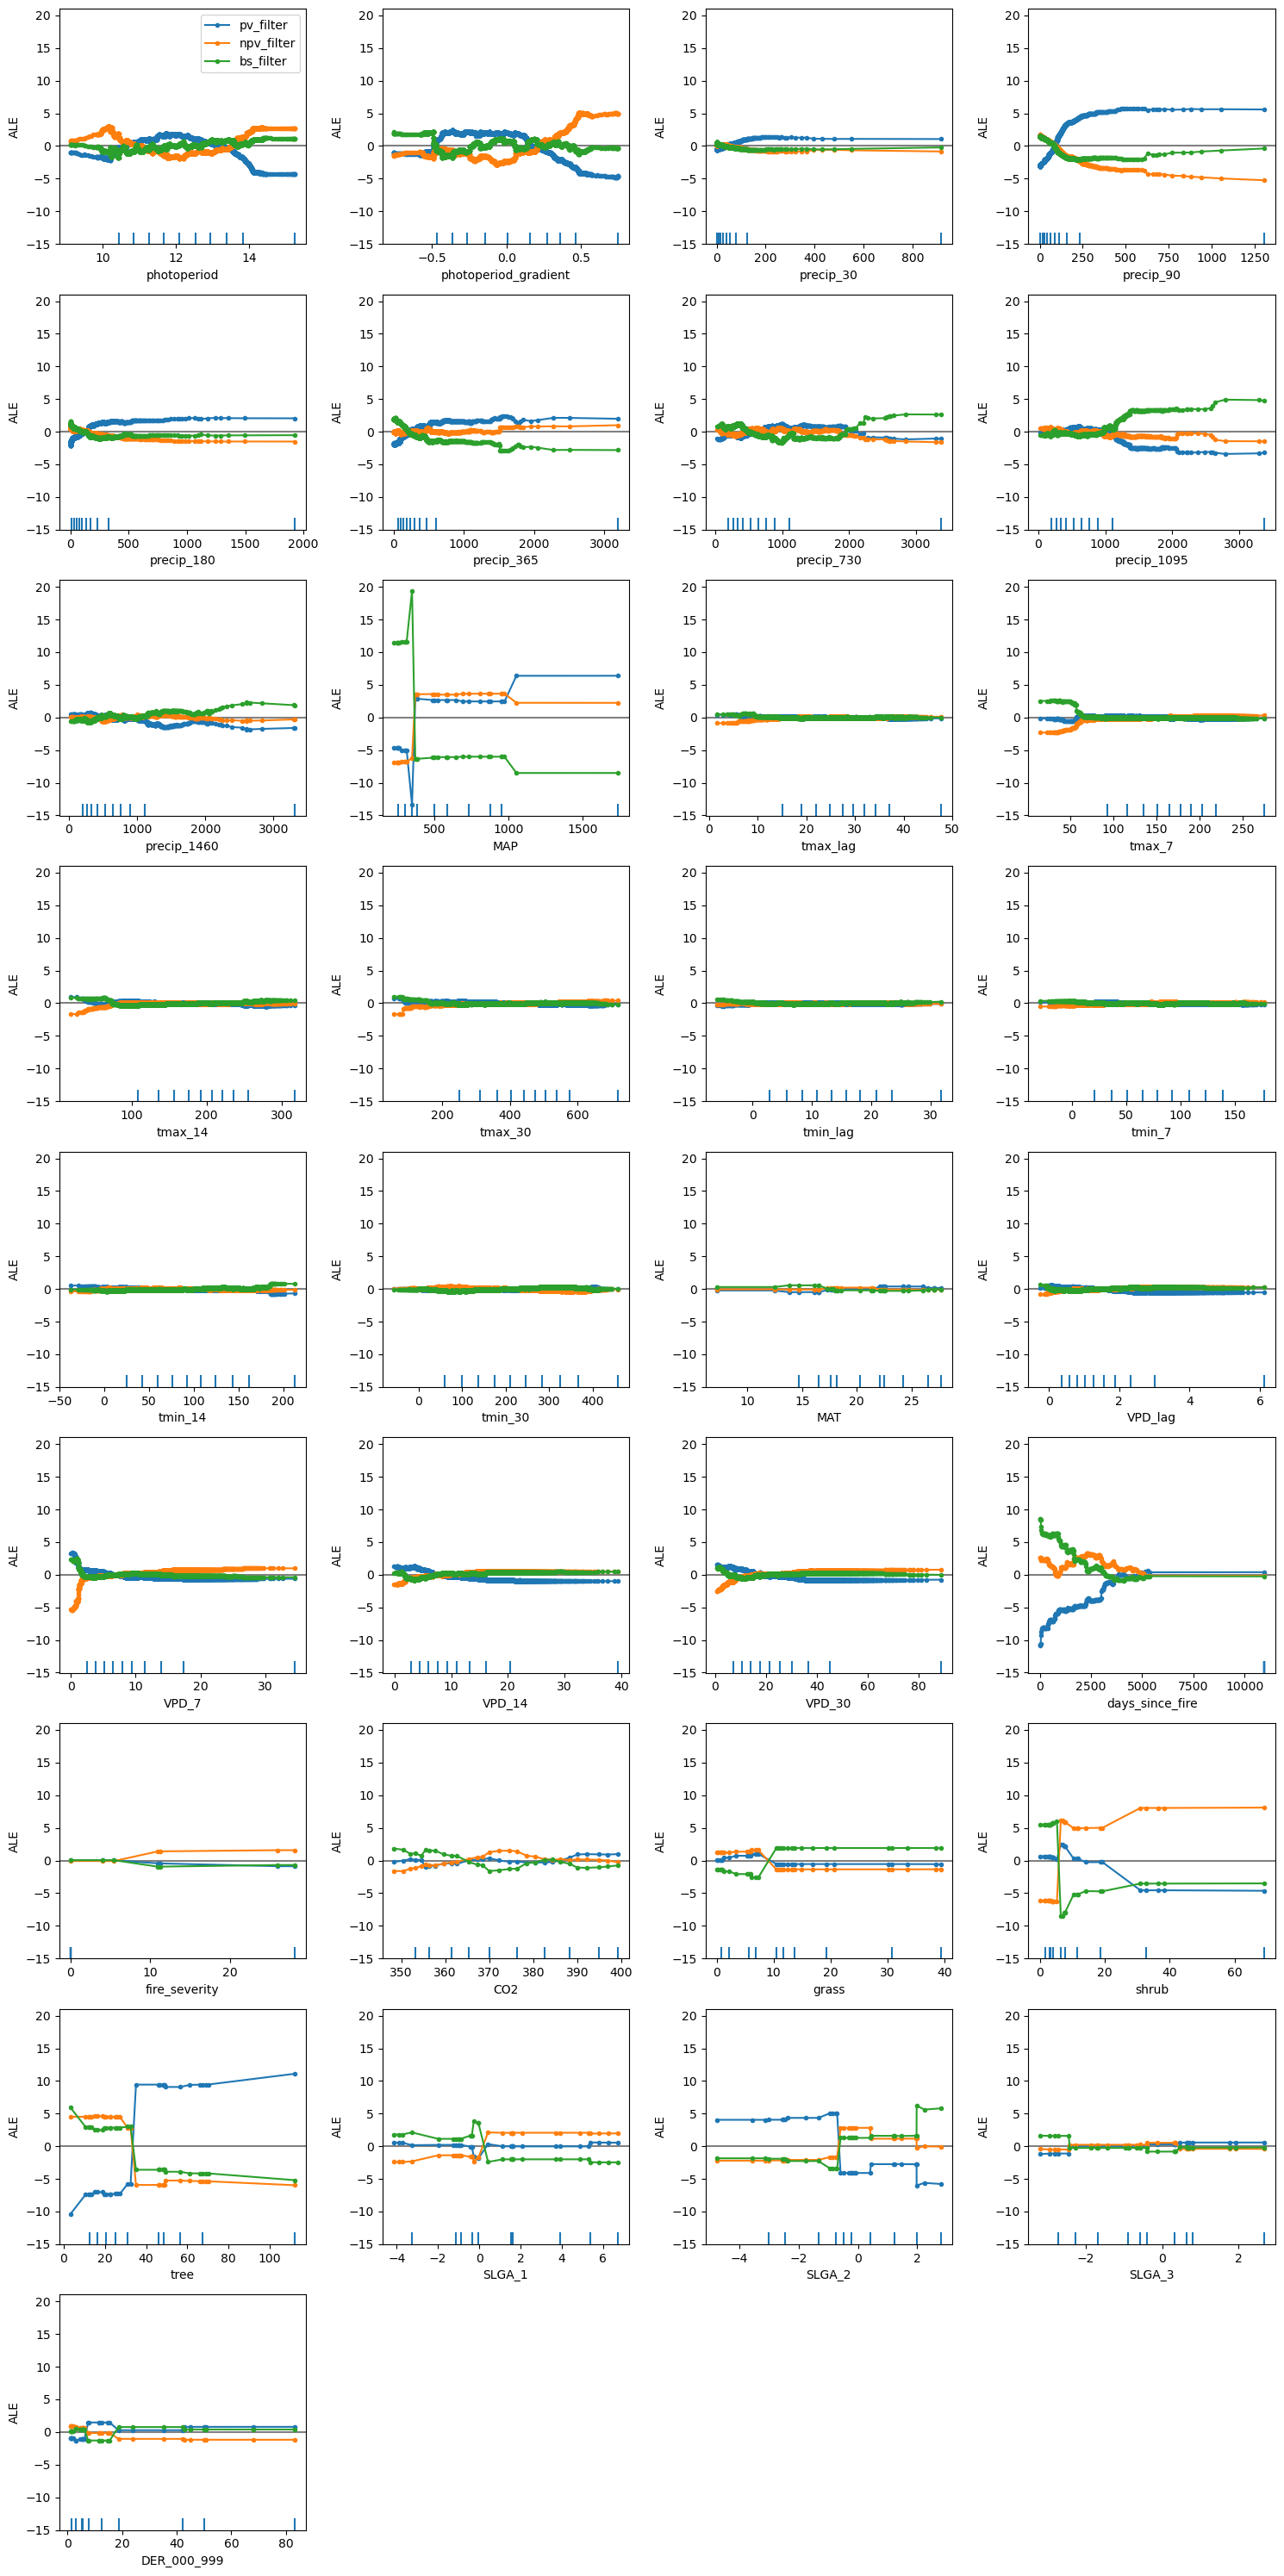

In [4]:
rf_ale = ALE(reg.predict, feature_names=FEATURES, target_names=TARGET)
rf_exp = rf_ale.explain(np.array(train[FEATURES]))
plot_ale(rf_exp, n_cols=4, fig_kw={'figwidth':15, 'figheight': 30});

The length of `target_names` does not match the number of predicted outputs. Ensure that the lengths match, otherwise a call to the `plot_pd` method might raise an error or produce undesired labeling.


array([[<Axes: xlabel='photoperiod', ylabel='pv_filter'>,
        <Axes: xlabel='photoperiod_gradient', ylabel='pv_filter'>,
        <Axes: xlabel='precip_30', ylabel='pv_filter'>,
        <Axes: xlabel='precip_90', ylabel='pv_filter'>],
       [<Axes: xlabel='precip_180', ylabel='pv_filter'>,
        <Axes: xlabel='precip_365', ylabel='pv_filter'>,
        <Axes: xlabel='precip_730', ylabel='pv_filter'>,
        <Axes: xlabel='precip_1095', ylabel='pv_filter'>],
       [<Axes: xlabel='precip_1460', ylabel='pv_filter'>,
        <Axes: xlabel='MAP', ylabel='pv_filter'>,
        <Axes: xlabel='tmax_lag', ylabel='pv_filter'>,
        <Axes: xlabel='tmax_7', ylabel='pv_filter'>],
       [<Axes: xlabel='tmax_14', ylabel='pv_filter'>,
        <Axes: xlabel='tmax_30', ylabel='pv_filter'>,
        <Axes: xlabel='tmin_lag', ylabel='pv_filter'>,
        <Axes: xlabel='tmin_7', ylabel='pv_filter'>],
       [<Axes: xlabel='tmin_14', ylabel='pv_filter'>,
        <Axes: xlabel='tmin_30', ylabel='pv_

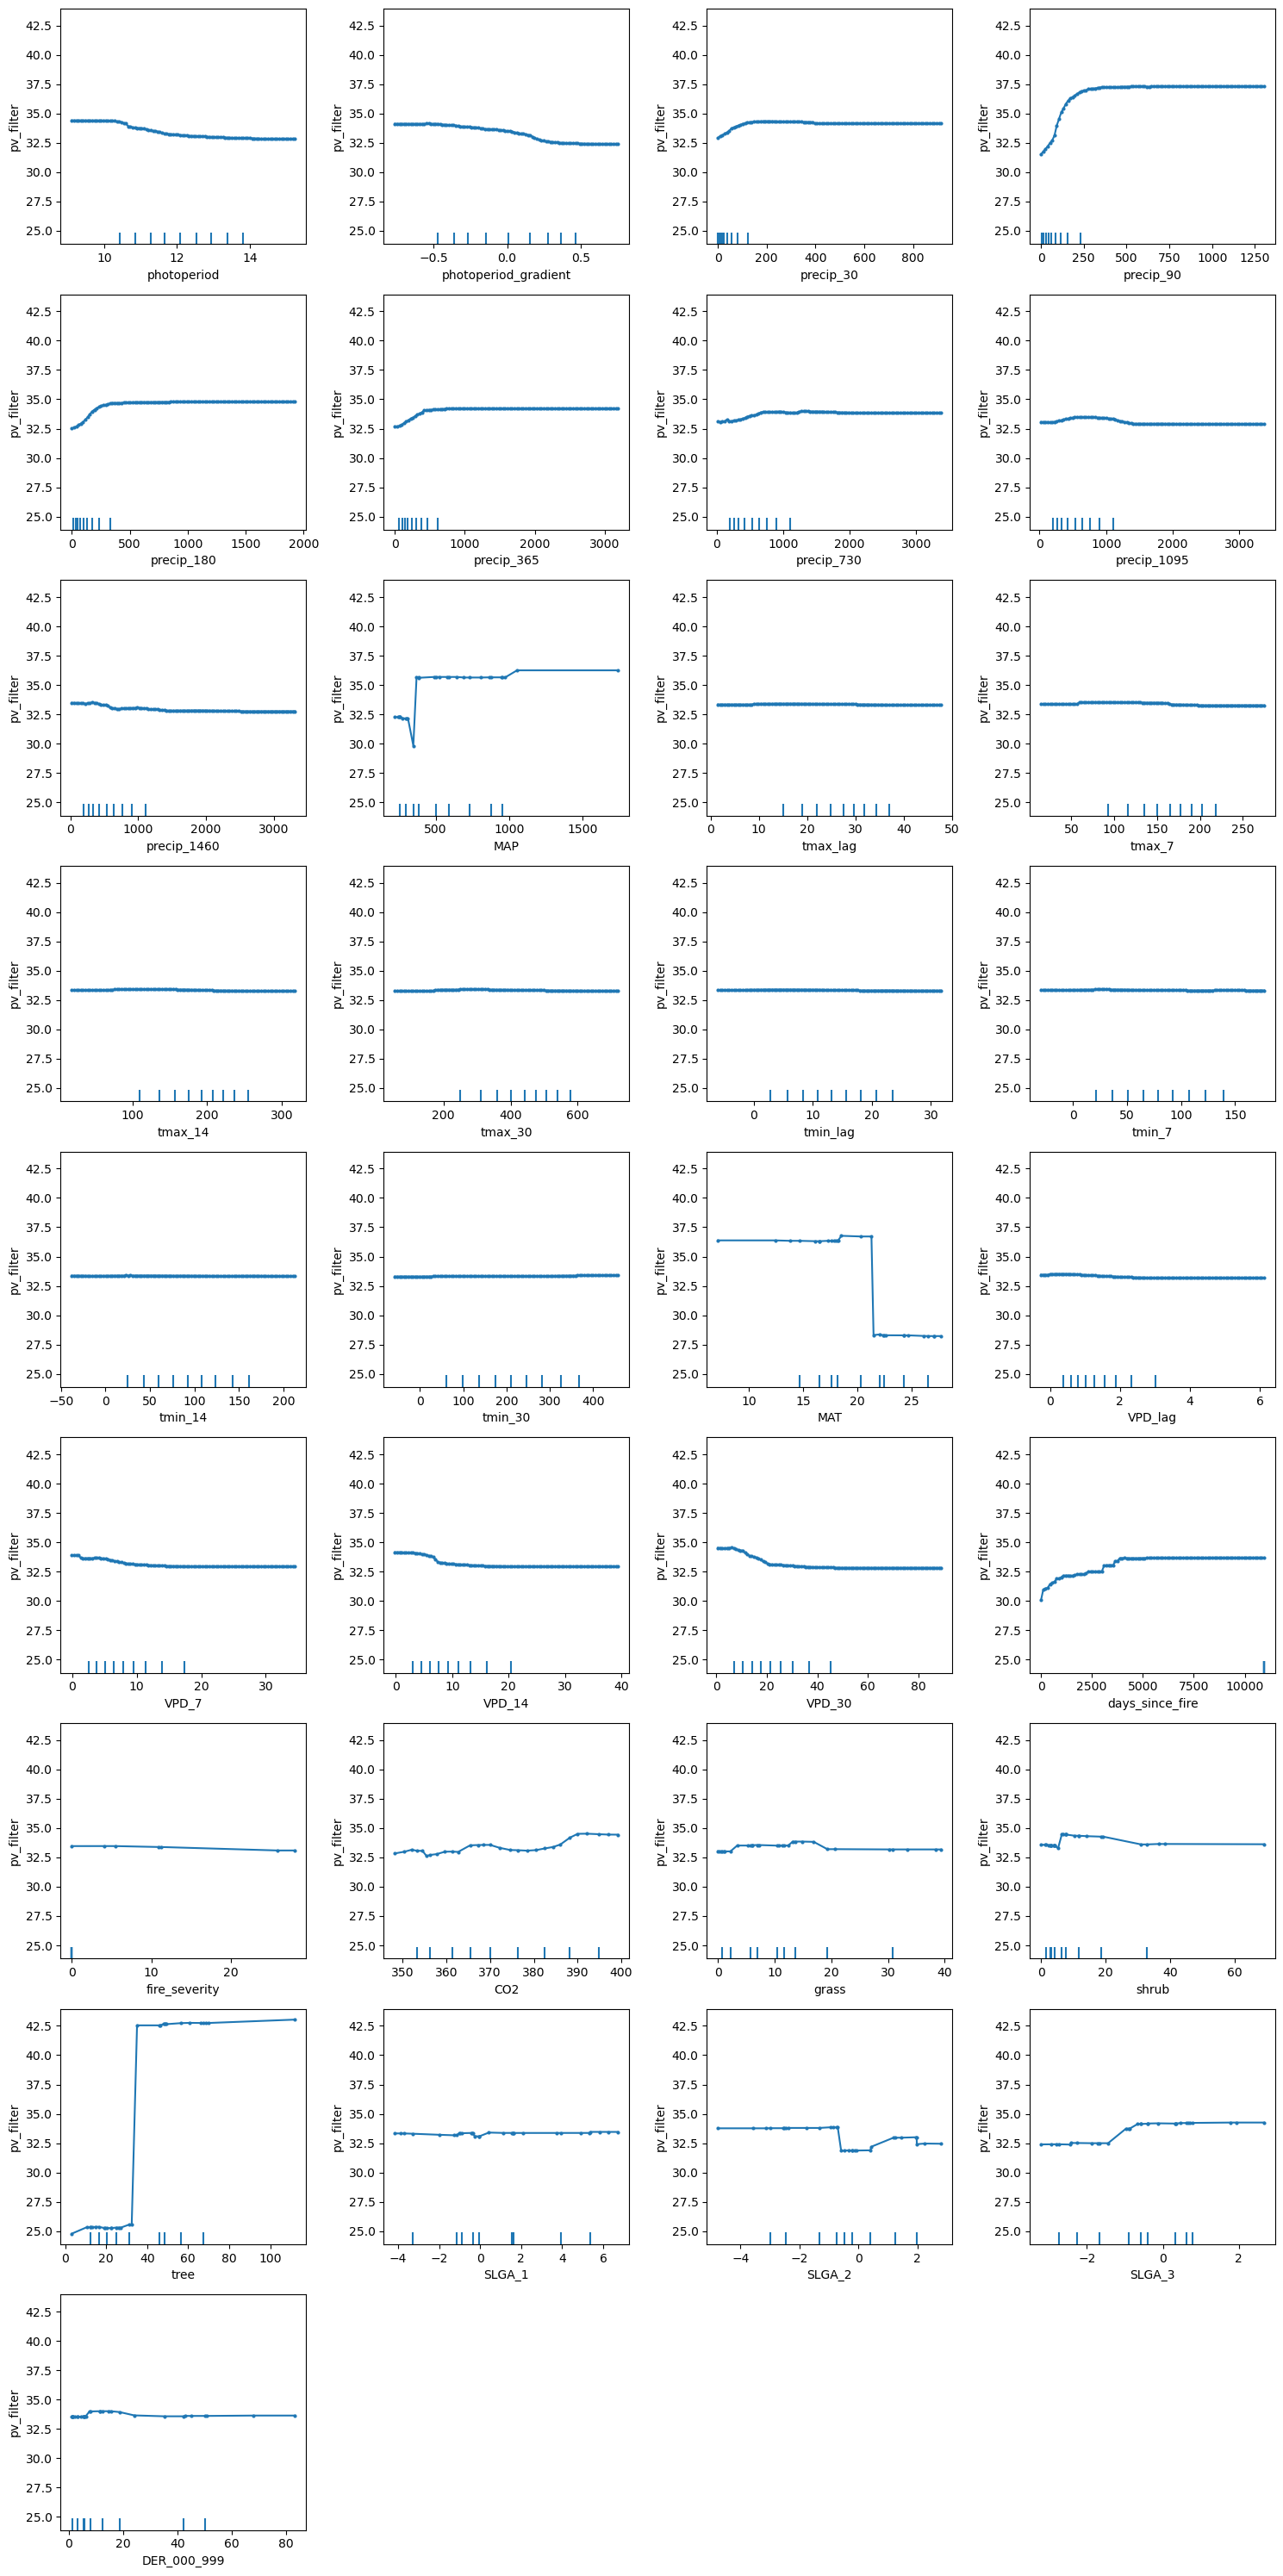

In [5]:
pd = PartialDependence(predictor= reg.predict,
                       feature_names= FEATURES,
                       target_names= ['pv_filter'])
exp = pd.explain(X= np.array(train[FEATURES]),
                 features= [i for i in range(len(FEATURES))],
                 kind='average')
plot_pd(exp=exp, n_cols=4, fig_kw={'figwidth':15, 'figheight': 30})

## Shrub Sites

In [6]:
# -*- coding: utf-8 -*-
"""
Created on Thu Apr  4 17:58:38 2024

@author: krish
"""

import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_validate
import graphviz 

import sys
sys.path.append('/Users/krish/Desktop/DYNAMIC MODEL VEGETATION PROJECT/au_dyanamic_vegetation_project/STEP9_DATA_MODELLING_AND_EXPLORATION')

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from PreprocessData import * # import from custom transformers
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import permutation_importance
from skopt import BayesSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import GroupKFold

#%% Functions 

def plotPredictions(actual, prediction, TARGET, msg = '', split = ''):
    fig, ax = plt.subplots(nrows = 3, figsize = (15,10))
    fig.suptitle(msg, fontsize=30)
    for i,v in enumerate(TARGET):
        actual[v].plot(ax=ax[i], color = 'blue', alpha = 0.4, linestyle='dashed' )
        prediction[f'prediction_{v}'].plot(ax=ax[i], color = 'orange', ylim = (0,100))
        ax[i].legend()
        if split:
            ax[i].axvline(time_split, color='black', ls='--')
            
def antiOverFitterScorer(y_train_pred, y_train_act, y_val_pred, y_val_act):
    train_score = -mean_squared_error(y_train_pred, y_train_act)
    val_score = -mean_squared_error(y_val_pred, y_val_act)
    score = ((train_score + val_score)/2) * val_score/train_score
    return score

tree_sites = ['NSABBS0001', 'NSACOP0001', 'NSAMDD0011', 'NSAMDD0020',
       'NSAMUL0003', 'NSANAN0001', 'NSANAN0002', 'NSANSS0001',
       'NSANSS0002', 'NSTSYB0003', 'NSTSYB0006', 'NTAFIN0003',
       'NTAFIN0015', 'NTAGFU0030', 'NTAGFU0034', 'QDABBN0002',
       'QDACHC0003', 'QDACYP0020', 'QDAGUP0006', 'QDAMGD0025',
       'QDAMUL0002', 'QDAMUL0003', 'QDASEQ0004', 'SAAFLB0008',
       'SATFLB0003', 'SATFLB0020', 'SATFLB0022', 'TCATCH0004',
       'WAACAR0002', 'WAAGAS0001', 'WAAPIL0023']

shrub_sites = ['NSABHC0011', 'NSAMDD0028', 'NSTSYB0005', 'NTAFIN0018',
       'QDABBS0010', 'QDACYP0018', 'QDAGUP0021', 'SAAEYB0021',
       'SAAEYB0028', 'SAAFLB0005', 'SAAGAW0008', 'SAAKAN0009',
       'SAASTP0023', 'SAASTP0033', 'SAASTP0034', 'SASMDD0009',
       'SASMDD0014', 'SATFLB0023', 'WAACAR0004', 'WAACOO0007',
       'WAACOO0016', 'WAACOO0024', 'WAACOO0026', 'WAACOO0027',
       'WAACOO0029', 'WAAGES0001', 'WAALSD0002', 'WAANUL0003',
       'WAAPIL0010']

grass_sites = ['NSABHC0023', 'NSAMDD0001', 'NSAMDD0014', 'NTADAC0001',
       'NTADMR0001', 'NTAFIN0002', 'NTAFIN0006', 'NTAGFU0014',
       'NTAGFU0020', 'NTAGFU0021', 'NTASTU0004', 'NTTDMR0003',
       'QDABBS0002', 'QDACYP0006', 'QDACYP0022', 'QDAEIU0005',
       'QDAEIU0010', 'QDAGUP0009', 'QDAGUP0019', 'QDAMGD0002',
       'QDAMGD0023', 'QDAMGD0024', 'QDASSD0015', 'SAAEYB0029',
       'SAAFLB0003', 'SASMDD0005', 'SATFLB0019', 'SATSTP0005',
       'TCATCH0006', 'TCATNM0001', 'TCATNM0003', 'VCAAUA0012',
       'WAAAVW0006', 'WAACOO0030', 'WAAGAS0002', 'WAANOK0006',
       'WAAPIL0003', 'WAAPIL0024', 'WAAPIL0031']

sites_list = shrub_sites

datasets = {}

for site_location_name in sites_list:
    
    site_merged = pd.read_csv(f'Input_DataSet_{site_location_name}.csv', parse_dates = ['time']).copy()
    datasets[site_location_name] = site_merged
    

#%% Model the dataset

SEASONAL_FEATURES = ['photoperiod', 'photoperiod_gradient']

PRECIP_FEATURES = ['precip_30', 'precip_90', 'precip_180', 
                   'precip_365', 'precip_730', 'precip_1095', 
                   'precip_1460', 'MAP']

TEMP_FEATURES = ['tmax_lag', 'tmax_7', 'tmax_14', 
                 'tmax_30', 'tmin_lag', 'tmin_7', 
                 'tmin_14', 'tmin_30', 'MAT']

VPD_FEATURES = ['VPD_lag','VPD_7', 'VPD_14',
                'VPD_30']

LAG_FEATURES = ['pv_lag', 'npv_lag', 'bs_lag']

LAGGED_CHANGE_FEATURES = ['pv_change', 'npv_change', 'bs_change']

FIRE_FEATURES = ['days_since_fire', 'fire_severity']

CO2_FEATURES = ['CO2']

VEGETATION_FEATURES = ['grass', 'shrub', 'tree']

SOIL_FEATURES = ['SLGA_1','SLGA_2','SLGA_3', 'DER_000_999'] # the soil attributes to include

FEATURES =  SEASONAL_FEATURES + PRECIP_FEATURES + TEMP_FEATURES + VPD_FEATURES + FIRE_FEATURES + CO2_FEATURES + VEGETATION_FEATURES + SOIL_FEATURES# final features 
TARGET = ['pv_filter', 'npv_filter', 'bs_filter']
site_merged = pd.concat(datasets).dropna(subset = FEATURES) # drop na based on chosen features, needed for random forest 
site_merged.sort_values('time', inplace = True)
site_merged.set_index('time', inplace = True)
scores = []
#%% Create Train/test set 
time_split = '2015-12-01' # This aprox splits the dataset from 80/20
train = site_merged.iloc[site_merged.index <= time_split]
test = site_merged.iloc[site_merged.index > time_split]
random_state = 20240228

#%% Run The model 

main_scorer = 'neg_mean_squared_error'
# Possible scorers:
    #  neg_mean_absolute_percentage_error'
    #  mean_squared_log_error
    # See more below:
    # https://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics
    

## Test with Default RF 
reg = RandomForestRegressor(n_estimators = 100, random_state = random_state, n_jobs = 7, oob_score = True)
reg.fit(X = train[FEATURES], y = train[TARGET])

RandomForestRegressor(n_jobs=7, oob_score=True, random_state=20240228)

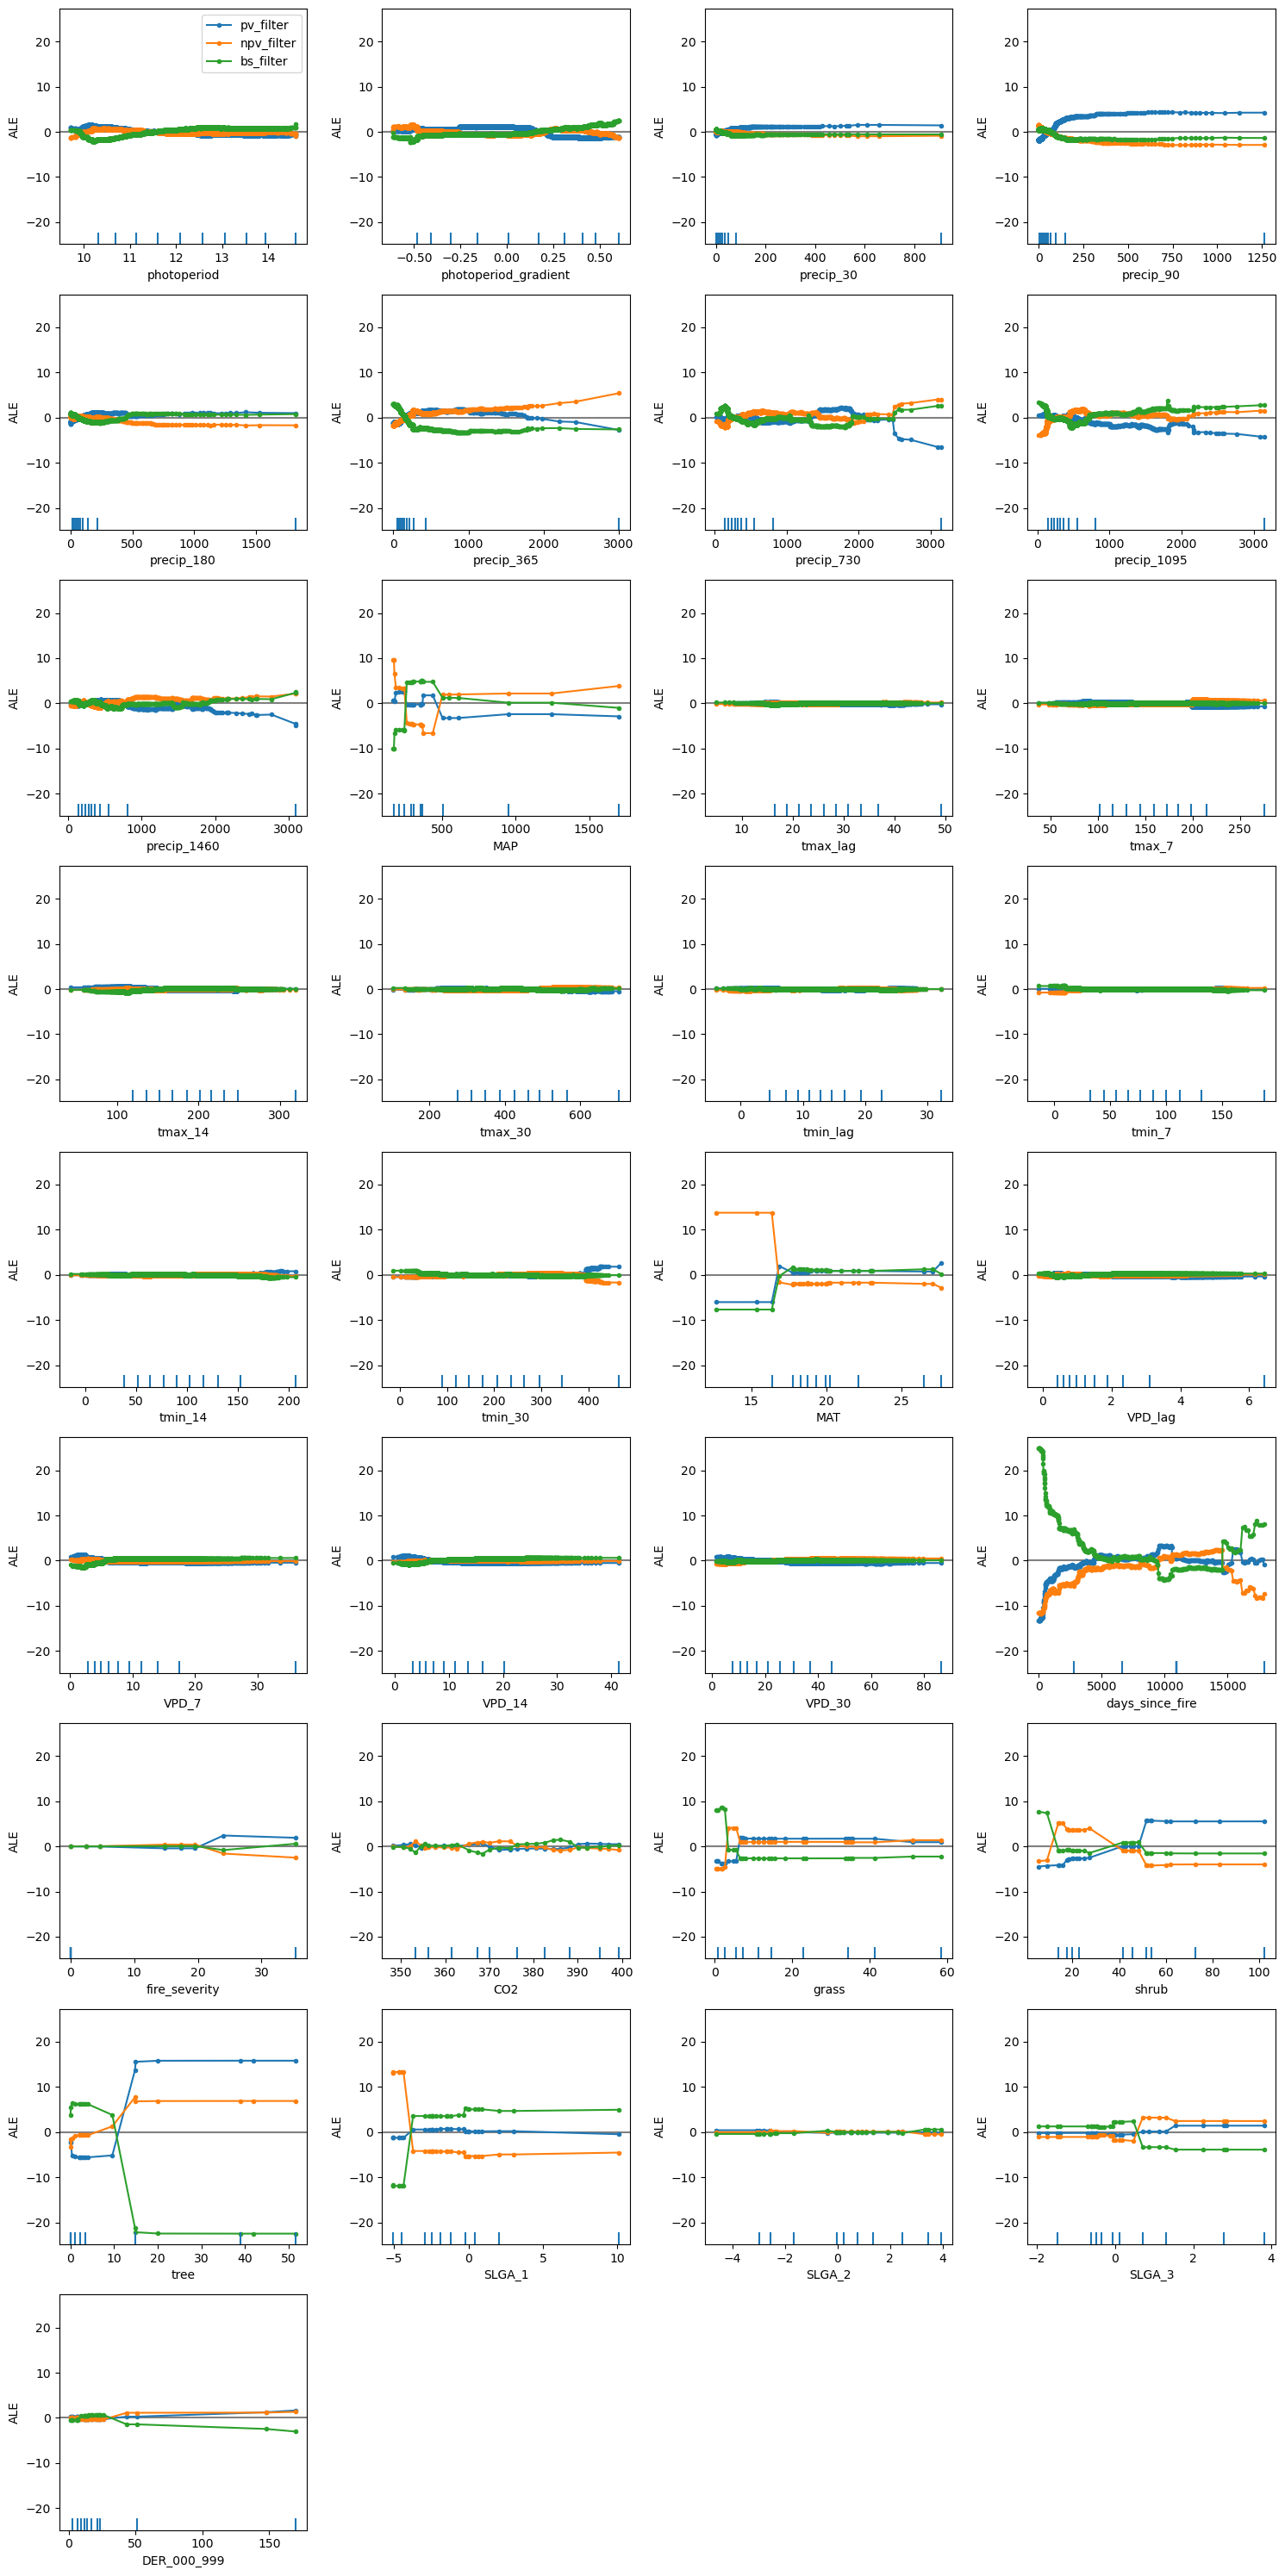

In [7]:
rf_ale = ALE(reg.predict, feature_names=FEATURES, target_names=TARGET)
rf_exp = rf_ale.explain(np.array(train[FEATURES]))
plot_ale(rf_exp, n_cols=4, fig_kw={'figwidth':15, 'figheight': 30});

The length of `target_names` does not match the number of predicted outputs. Ensure that the lengths match, otherwise a call to the `plot_pd` method might raise an error or produce undesired labeling.


array([[<Axes: xlabel='photoperiod', ylabel='pv_filter'>,
        <Axes: xlabel='photoperiod_gradient', ylabel='pv_filter'>,
        <Axes: xlabel='precip_30', ylabel='pv_filter'>,
        <Axes: xlabel='precip_90', ylabel='pv_filter'>],
       [<Axes: xlabel='precip_180', ylabel='pv_filter'>,
        <Axes: xlabel='precip_365', ylabel='pv_filter'>,
        <Axes: xlabel='precip_730', ylabel='pv_filter'>,
        <Axes: xlabel='precip_1095', ylabel='pv_filter'>],
       [<Axes: xlabel='precip_1460', ylabel='pv_filter'>,
        <Axes: xlabel='MAP', ylabel='pv_filter'>,
        <Axes: xlabel='tmax_lag', ylabel='pv_filter'>,
        <Axes: xlabel='tmax_7', ylabel='pv_filter'>],
       [<Axes: xlabel='tmax_14', ylabel='pv_filter'>,
        <Axes: xlabel='tmax_30', ylabel='pv_filter'>,
        <Axes: xlabel='tmin_lag', ylabel='pv_filter'>,
        <Axes: xlabel='tmin_7', ylabel='pv_filter'>],
       [<Axes: xlabel='tmin_14', ylabel='pv_filter'>,
        <Axes: xlabel='tmin_30', ylabel='pv_

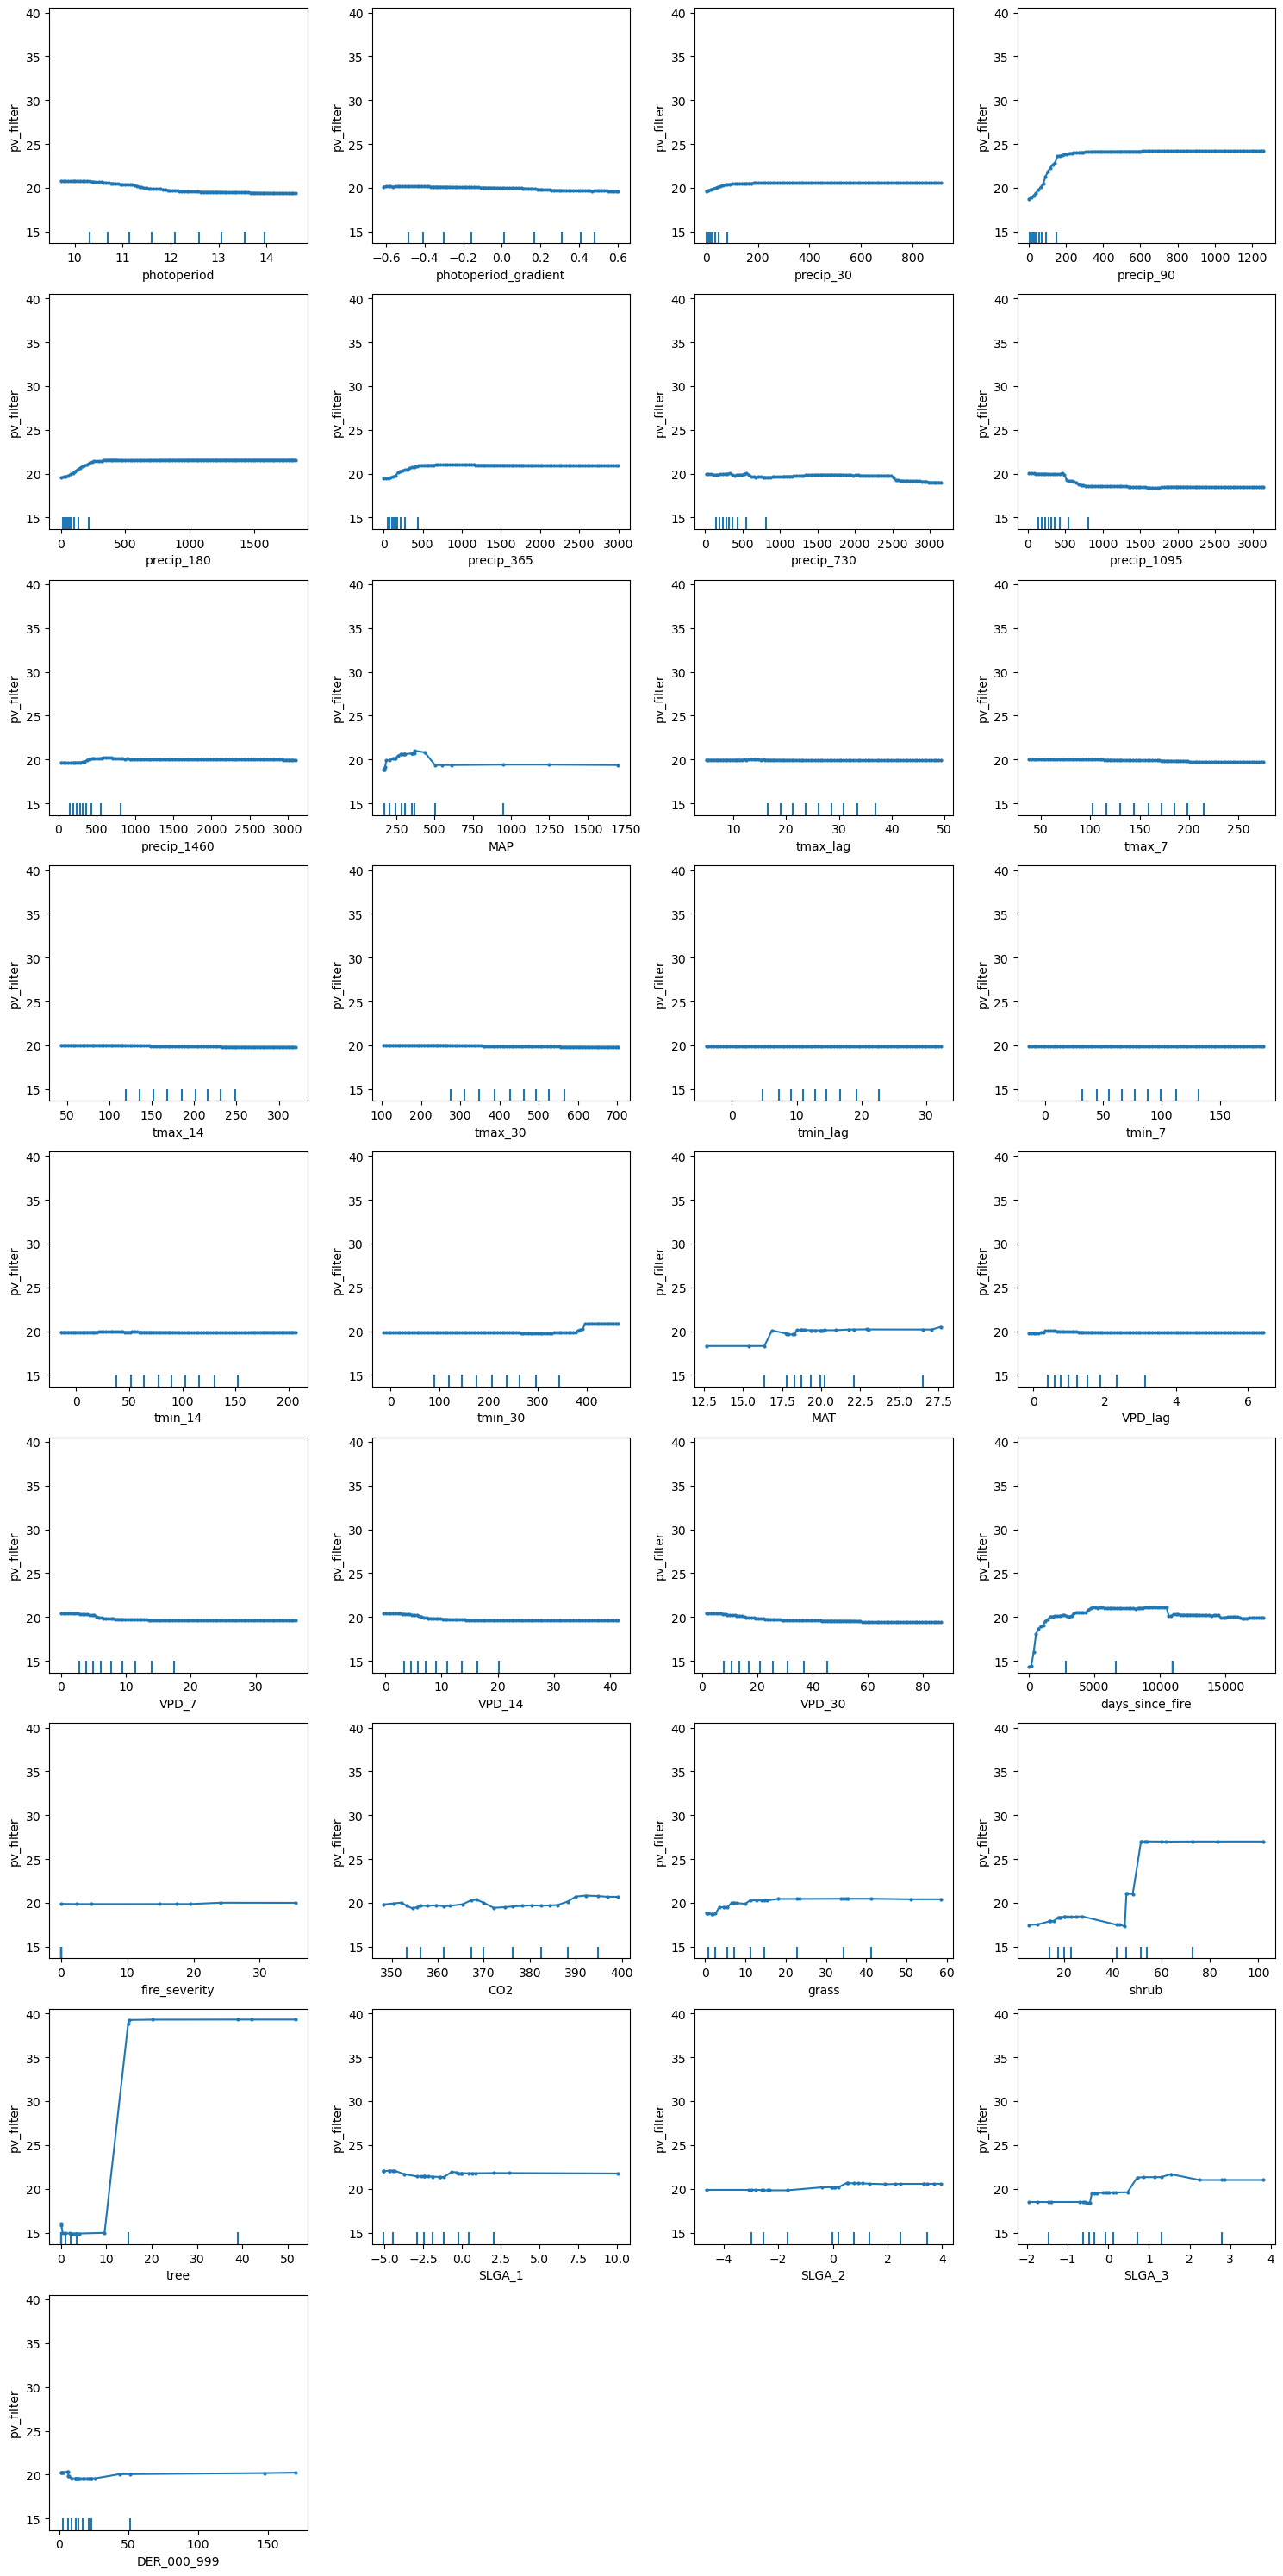

In [8]:
pd = PartialDependence(predictor= reg.predict,
                       feature_names= FEATURES,
                       target_names= ['pv_filter'])
exp = pd.explain(X= np.array(train[FEATURES]),
                 features= [i for i in range(len(FEATURES))],
                 kind='average')
plot_pd(exp=exp, n_cols=4, fig_kw={'figwidth':15, 'figheight': 30})

# Grass Sites

In [9]:
# -*- coding: utf-8 -*-
"""
Created on Thu Apr  4 17:58:38 2024

@author: krish
"""

import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_validate
import graphviz 

import sys
sys.path.append('/Users/krish/Desktop/DYNAMIC MODEL VEGETATION PROJECT/au_dyanamic_vegetation_project/STEP9_DATA_MODELLING_AND_EXPLORATION')

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from PreprocessData import * # import from custom transformers
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import permutation_importance
from skopt import BayesSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import GroupKFold

#%% Functions 

def plotPredictions(actual, prediction, TARGET, msg = '', split = ''):
    fig, ax = plt.subplots(nrows = 3, figsize = (15,10))
    fig.suptitle(msg, fontsize=30)
    for i,v in enumerate(TARGET):
        actual[v].plot(ax=ax[i], color = 'blue', alpha = 0.4, linestyle='dashed' )
        prediction[f'prediction_{v}'].plot(ax=ax[i], color = 'orange', ylim = (0,100))
        ax[i].legend()
        if split:
            ax[i].axvline(time_split, color='black', ls='--')
            
def antiOverFitterScorer(y_train_pred, y_train_act, y_val_pred, y_val_act):
    train_score = -mean_squared_error(y_train_pred, y_train_act)
    val_score = -mean_squared_error(y_val_pred, y_val_act)
    score = ((train_score + val_score)/2) * val_score/train_score
    return score

tree_sites = ['NSABBS0001', 'NSACOP0001', 'NSAMDD0011', 'NSAMDD0020',
       'NSAMUL0003', 'NSANAN0001', 'NSANAN0002', 'NSANSS0001',
       'NSANSS0002', 'NSTSYB0003', 'NSTSYB0006', 'NTAFIN0003',
       'NTAFIN0015', 'NTAGFU0030', 'NTAGFU0034', 'QDABBN0002',
       'QDACHC0003', 'QDACYP0020', 'QDAGUP0006', 'QDAMGD0025',
       'QDAMUL0002', 'QDAMUL0003', 'QDASEQ0004', 'SAAFLB0008',
       'SATFLB0003', 'SATFLB0020', 'SATFLB0022', 'TCATCH0004',
       'WAACAR0002', 'WAAGAS0001', 'WAAPIL0023']

shrub_sites = ['NSABHC0011', 'NSAMDD0028', 'NSTSYB0005', 'NTAFIN0018',
       'QDABBS0010', 'QDACYP0018', 'QDAGUP0021', 'SAAEYB0021',
       'SAAEYB0028', 'SAAFLB0005', 'SAAGAW0008', 'SAAKAN0009',
       'SAASTP0023', 'SAASTP0033', 'SAASTP0034', 'SASMDD0009',
       'SASMDD0014', 'SATFLB0023', 'WAACAR0004', 'WAACOO0007',
       'WAACOO0016', 'WAACOO0024', 'WAACOO0026', 'WAACOO0027',
       'WAACOO0029', 'WAAGES0001', 'WAALSD0002', 'WAANUL0003',
       'WAAPIL0010']

grass_sites = ['NSABHC0023', 'NSAMDD0001', 'NSAMDD0014', 'NTADAC0001',
       'NTADMR0001', 'NTAFIN0002', 'NTAFIN0006', 'NTAGFU0014',
       'NTAGFU0020', 'NTAGFU0021', 'NTASTU0004', 'NTTDMR0003',
       'QDABBS0002', 'QDACYP0006', 'QDACYP0022', 'QDAEIU0005',
       'QDAEIU0010', 'QDAGUP0009', 'QDAGUP0019', 'QDAMGD0002',
       'QDAMGD0023', 'QDAMGD0024', 'QDASSD0015', 'SAAEYB0029',
       'SAAFLB0003', 'SASMDD0005', 'SATFLB0019', 'SATSTP0005',
       'TCATCH0006', 'TCATNM0001', 'TCATNM0003', 'VCAAUA0012',
       'WAAAVW0006', 'WAACOO0030', 'WAAGAS0002', 'WAANOK0006',
       'WAAPIL0003', 'WAAPIL0024', 'WAAPIL0031']

sites_list = grass_sites

datasets = {}

for site_location_name in sites_list:
    
    site_merged = pd.read_csv(f'Input_DataSet_{site_location_name}.csv', parse_dates = ['time']).copy()
    datasets[site_location_name] = site_merged
    

#%% Model the dataset

SEASONAL_FEATURES = ['photoperiod', 'photoperiod_gradient']

PRECIP_FEATURES = ['precip_30', 'precip_90', 'precip_180', 
                   'precip_365', 'precip_730', 'precip_1095', 
                   'precip_1460', 'MAP']

TEMP_FEATURES = ['tmax_lag', 'tmax_7', 'tmax_14', 
                 'tmax_30', 'tmin_lag', 'tmin_7', 
                 'tmin_14', 'tmin_30', 'MAT']

VPD_FEATURES = ['VPD_lag','VPD_7', 'VPD_14',
                'VPD_30']

LAG_FEATURES = ['pv_lag', 'npv_lag', 'bs_lag']

LAGGED_CHANGE_FEATURES = ['pv_change', 'npv_change', 'bs_change']

FIRE_FEATURES = ['days_since_fire', 'fire_severity']

CO2_FEATURES = ['CO2']

VEGETATION_FEATURES = ['grass', 'shrub', 'tree']

SOIL_FEATURES = ['SLGA_1','SLGA_2','SLGA_3', 'DER_000_999'] # the soil attributes to include

FEATURES =  SEASONAL_FEATURES + PRECIP_FEATURES + TEMP_FEATURES + VPD_FEATURES + FIRE_FEATURES + CO2_FEATURES + VEGETATION_FEATURES + SOIL_FEATURES# final features 
TARGET = ['pv_filter', 'npv_filter', 'bs_filter']
site_merged = pd.concat(datasets).dropna(subset = FEATURES) # drop na based on chosen features, needed for random forest 
site_merged.sort_values('time', inplace = True)
site_merged.set_index('time', inplace = True)
scores = []
#%% Create Train/test set 
time_split = '2015-12-01' # This aprox splits the dataset from 80/20
train = site_merged.iloc[site_merged.index <= time_split]
test = site_merged.iloc[site_merged.index > time_split]
random_state = 20240228

#%% Run The model 

main_scorer = 'neg_mean_squared_error'
# Possible scorers:
    #  neg_mean_absolute_percentage_error'
    #  mean_squared_log_error
    # See more below:
    # https://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics
    

## Test with Default RF 
reg = RandomForestRegressor(n_estimators = 100, random_state = random_state, n_jobs = 7, oob_score = True)
reg.fit(X = train[FEATURES], y = train[TARGET])

RandomForestRegressor(n_jobs=7, oob_score=True, random_state=20240228)

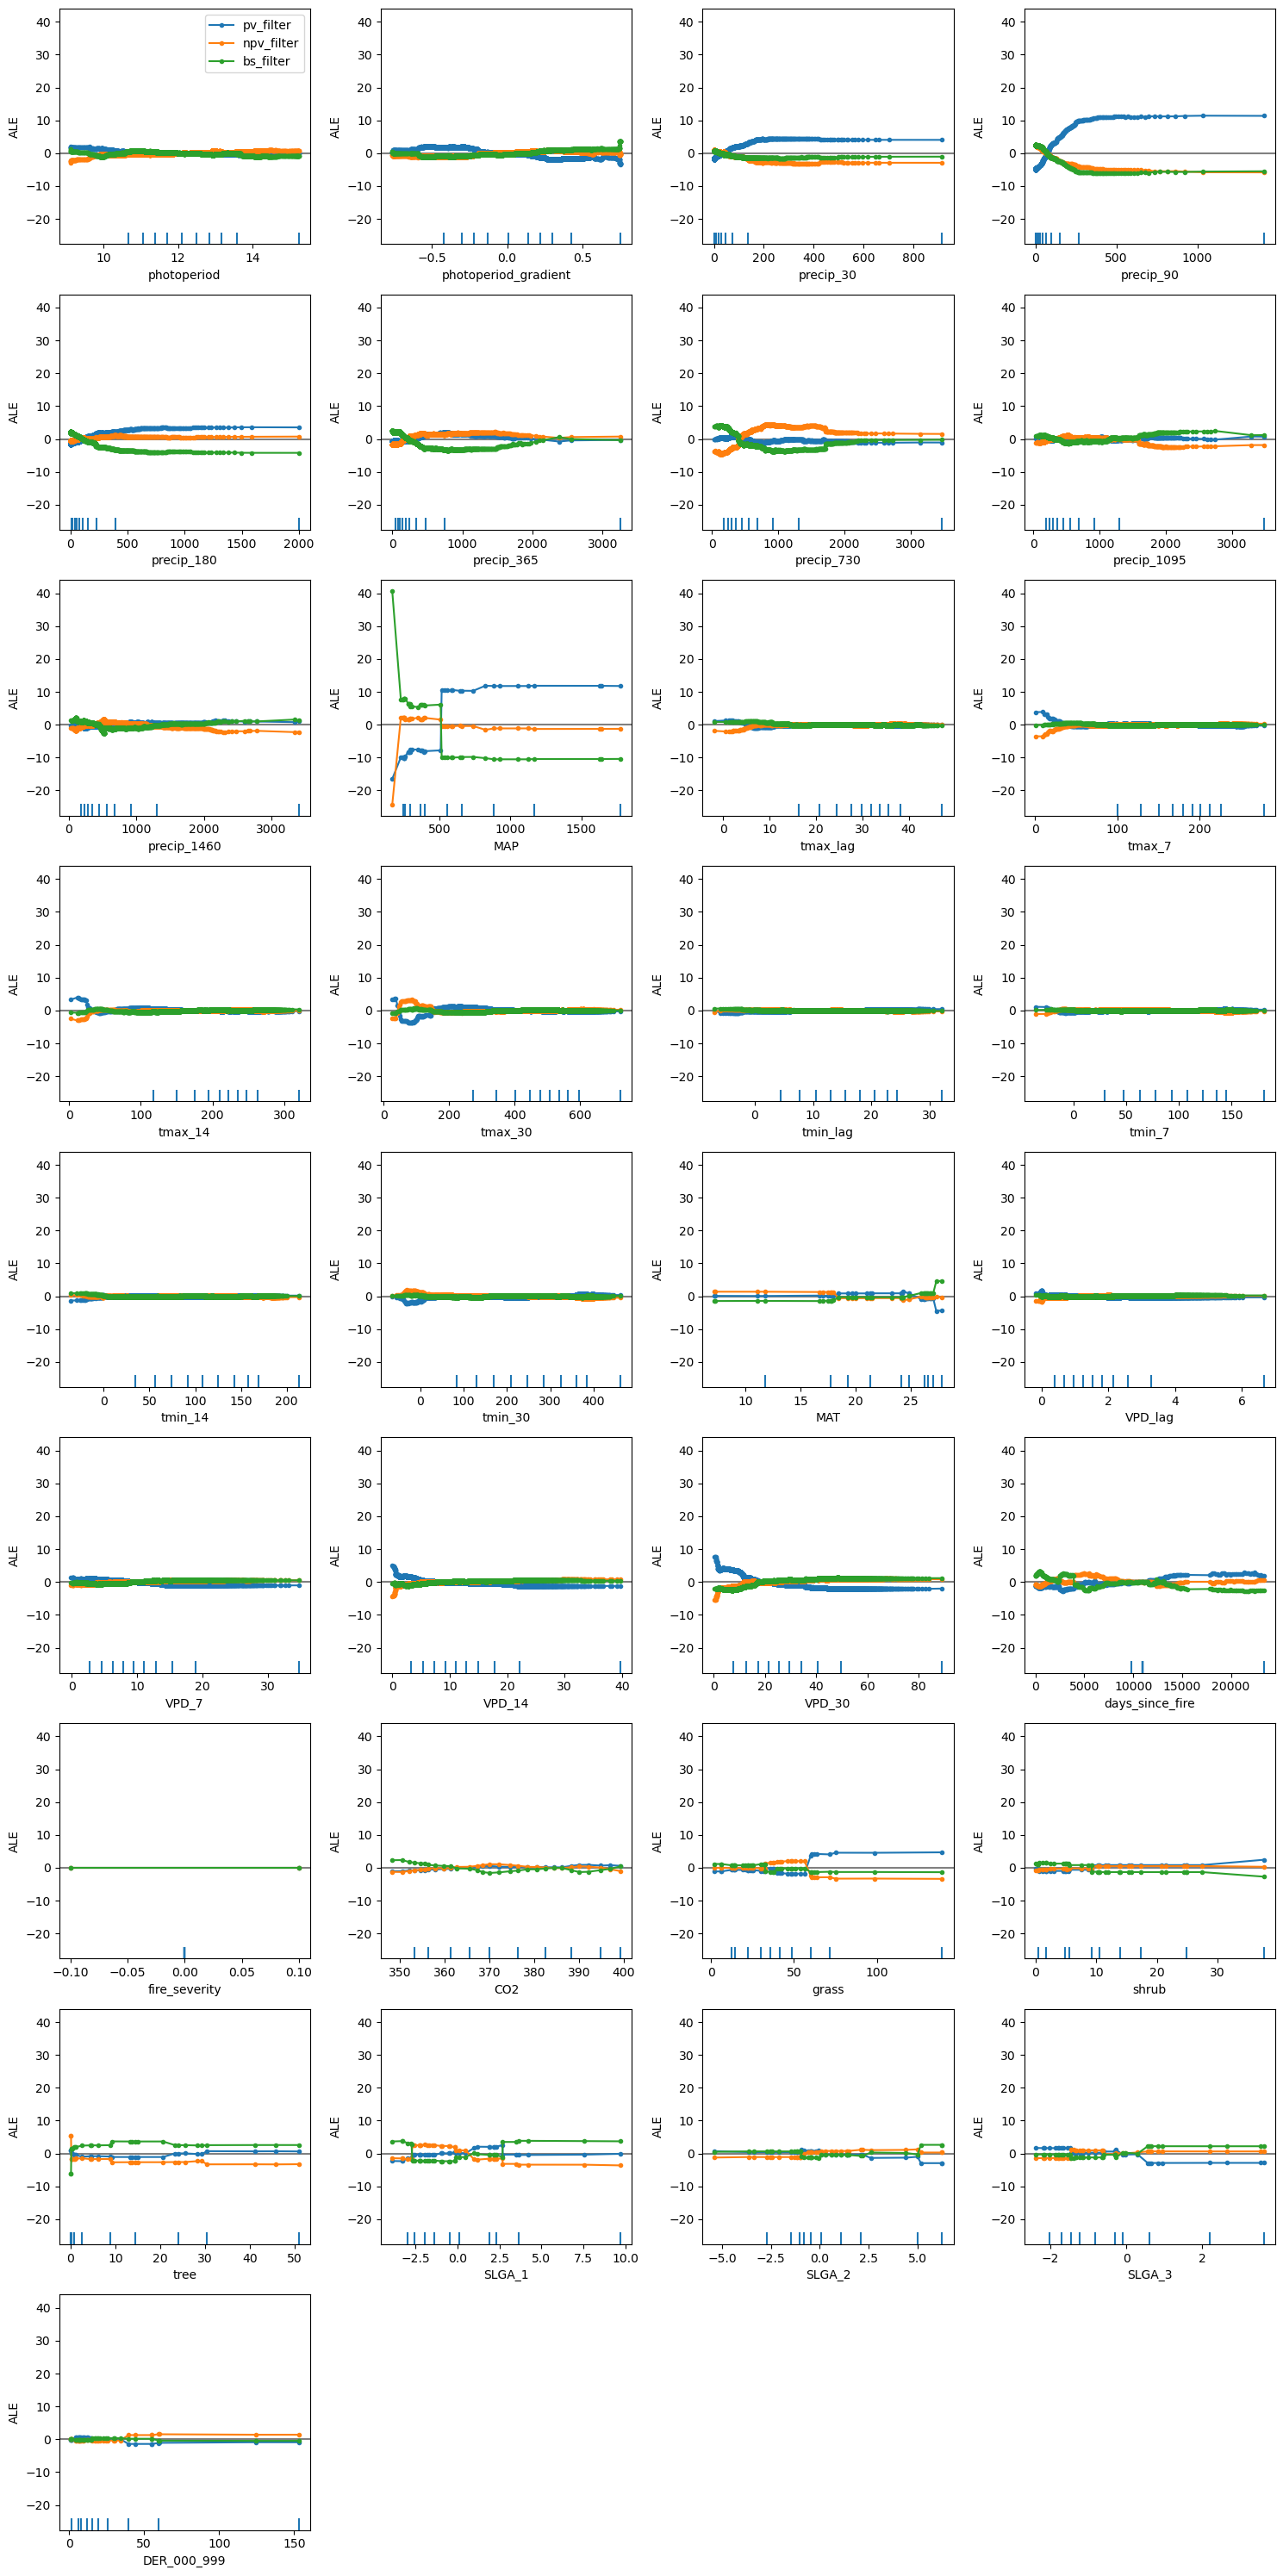

In [10]:
rf_ale = ALE(reg.predict, feature_names=FEATURES, target_names=TARGET)
rf_exp = rf_ale.explain(np.array(train[FEATURES]))
plot_ale(rf_exp, n_cols=4, fig_kw={'figwidth':15, 'figheight': 30});

The length of `target_names` does not match the number of predicted outputs. Ensure that the lengths match, otherwise a call to the `plot_pd` method might raise an error or produce undesired labeling.


array([[<Axes: xlabel='photoperiod', ylabel='pv_filter'>,
        <Axes: xlabel='photoperiod_gradient', ylabel='pv_filter'>,
        <Axes: xlabel='precip_30', ylabel='pv_filter'>,
        <Axes: xlabel='precip_90', ylabel='pv_filter'>],
       [<Axes: xlabel='precip_180', ylabel='pv_filter'>,
        <Axes: xlabel='precip_365', ylabel='pv_filter'>,
        <Axes: xlabel='precip_730', ylabel='pv_filter'>,
        <Axes: xlabel='precip_1095', ylabel='pv_filter'>],
       [<Axes: xlabel='precip_1460', ylabel='pv_filter'>,
        <Axes: xlabel='MAP', ylabel='pv_filter'>,
        <Axes: xlabel='tmax_lag', ylabel='pv_filter'>,
        <Axes: xlabel='tmax_7', ylabel='pv_filter'>],
       [<Axes: xlabel='tmax_14', ylabel='pv_filter'>,
        <Axes: xlabel='tmax_30', ylabel='pv_filter'>,
        <Axes: xlabel='tmin_lag', ylabel='pv_filter'>,
        <Axes: xlabel='tmin_7', ylabel='pv_filter'>],
       [<Axes: xlabel='tmin_14', ylabel='pv_filter'>,
        <Axes: xlabel='tmin_30', ylabel='pv_

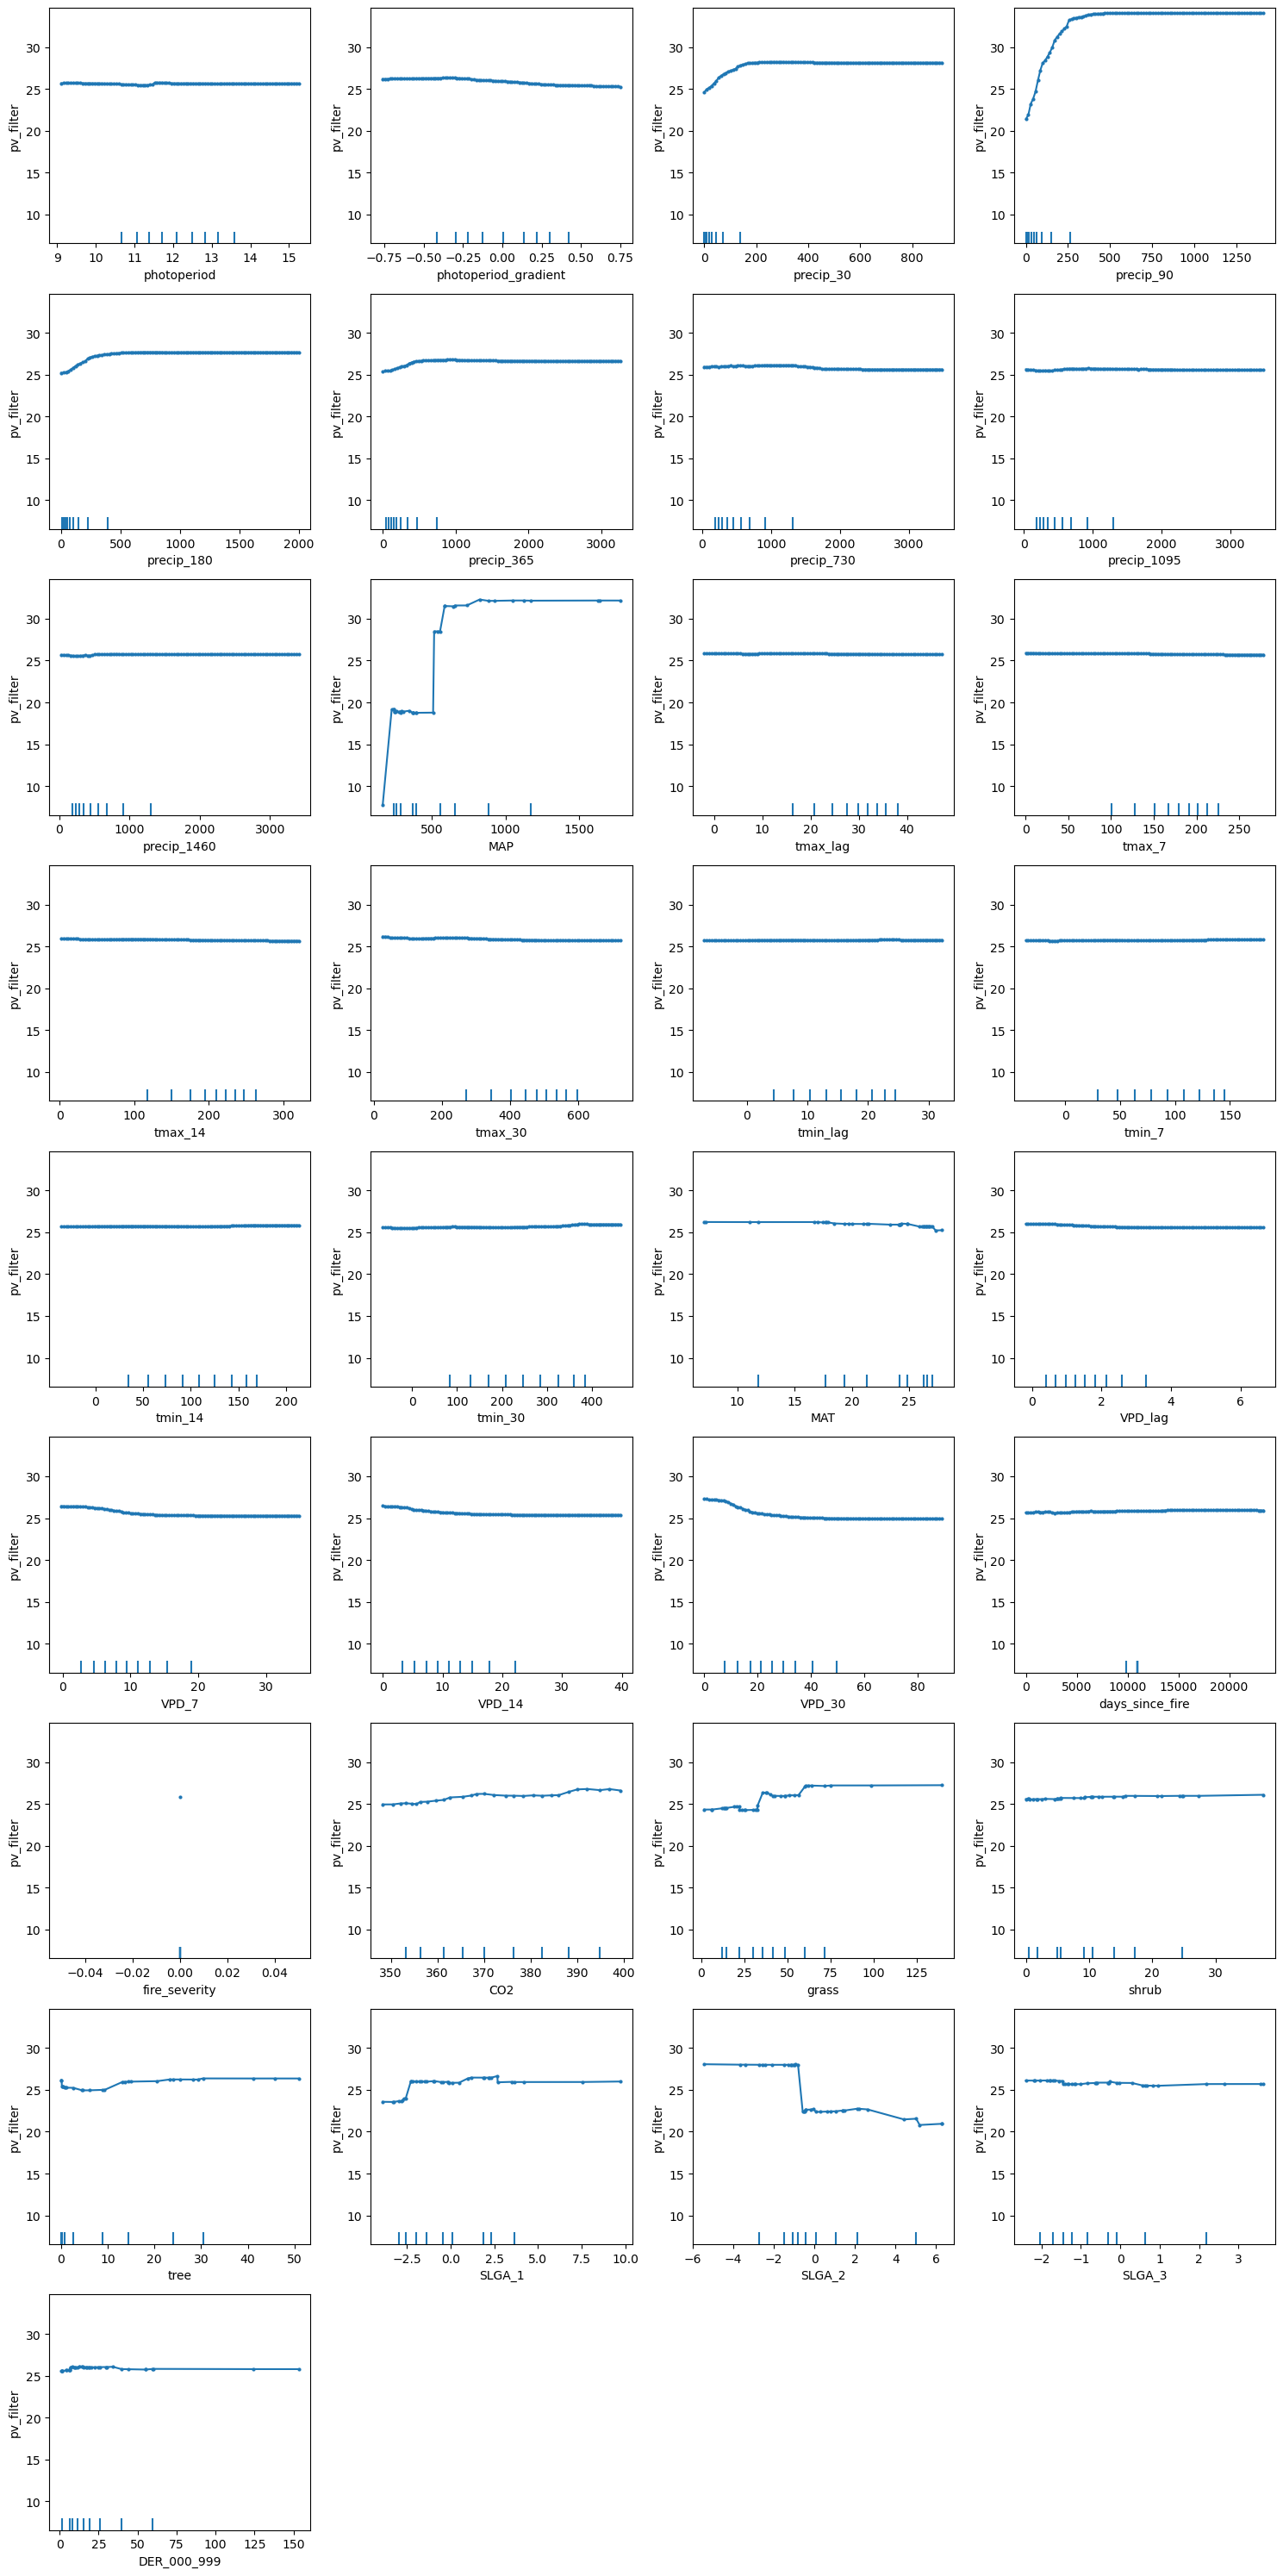

In [11]:
pd = PartialDependence(predictor= reg.predict,
                       feature_names= FEATURES,
                       target_names= ['pv_filter'])
exp = pd.explain(X= np.array(train[FEATURES]),
                 features= [i for i in range(len(FEATURES))],
                 kind='average')
plot_pd(exp=exp, n_cols=4, fig_kw={'figwidth':15, 'figheight': 30})